# Main document

### Initialization 

In [ ]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BaseNetwork import BuildBaseNetwork
import logging
# Mute PyPSA, Linopy, and Gurobipy logging
logging.getLogger("pypsa").setLevel(logging.ERROR)
logging.getLogger("linopy").setLevel(logging.ERROR)
logging.getLogger("gurobipy").setLevel(logging.ERROR)

# Optional: Mute all logging (be careful if you still want to see your own logs)
logging.getLogger().setLevel(logging.CRITICAL)


# Task A

In [7]:

# Basemodel with DK and DE
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
                }

tmp = BuildBaseNetwork(year=2017, cost_year = 2030, setup = setup, demand_year=2019)

In [8]:
tmp.network.optimize(solver_name="gurobi",solver_options={"OutputFlag": 0})

Index(['electricity bus DK'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 26.56it/s]
INFO:linopy.io: Writing time: 0.53s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-ws1hcejo.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-ws1hcejo.lp


Reading time = 0.16 seconds


INFO:gurobipy.gurobipy:Reading time = 0.16 seconds


obj: 78845 rows, 35044 columns, 135802 nonzeros


INFO:gurobipy.gurobipy:obj: 78845 rows, 35044 columns, 135802 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35044 primals, 78845 duals
Objective: 2.17e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [9]:
# Print the results
print("_____________Optimal generation mix_____________")
print(tmp.network.generators.p_nom_opt)

_____________Optimal generation mix_____________
Generator
OCGT DK       5321.005850
solar DK      1224.534474
offwind DK     798.276665
onwind DK     5500.000000
Name: p_nom_opt, dtype: float64


In [10]:
# print the results as a table 
import pandas as pd

# Example data (you would use tmp.network.generators.p_nom_opt directly)
p_nom_opt = tmp.network.generators.p_nom_opt

# Convert to DataFrame for easier formatting
df = p_nom_opt.reset_index()
df.columns = ['Generator', 'Optimized Capacity (MW)']

# Format LaTeX table
latex_table = df.to_latex(index=False, float_format="%.2f", caption="Optimized Generator Capacities - DK", label="tab:gen_capacities")

print(latex_table)


\begin{table}
\caption{Optimized Generator Capacities - DK}
\label{tab:gen_capacities}
\begin{tabular}{lr}
\toprule
Generator & Optimized Capacity (MW) \\
\midrule
OCGT DK & 5321.01 \\
solar DK & 1224.53 \\
offwind DK & 798.28 \\
onwind DK & 5500.00 \\
\bottomrule
\end{tabular}
\end{table}



### Plots - Task A

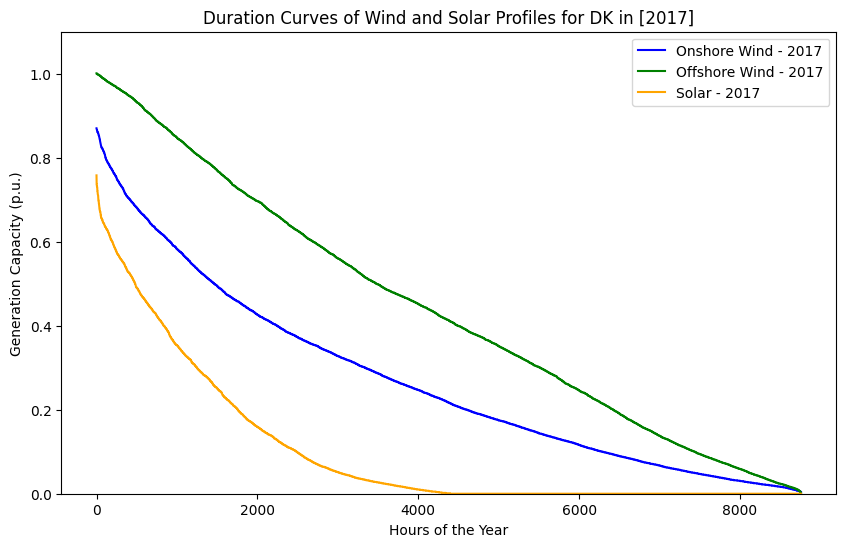

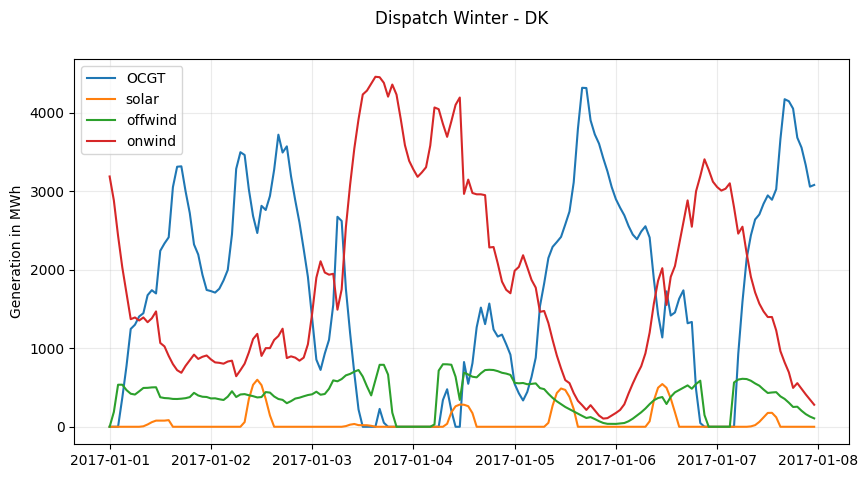

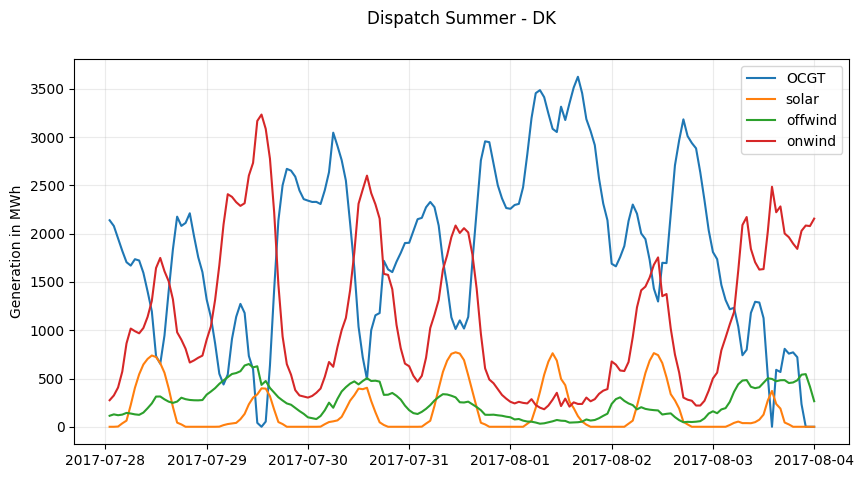

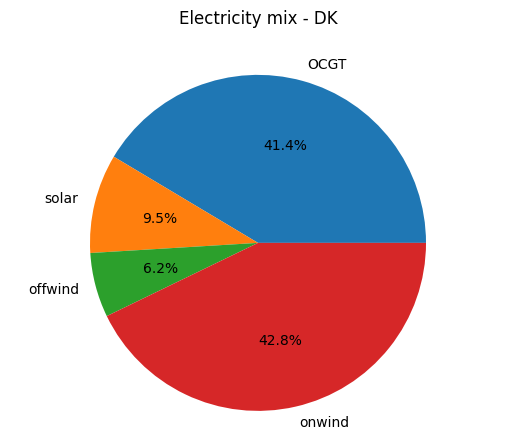

In [11]:
from PlotDispatch import PlotDispatch
from AnnualElectricityMix import AnnualElectricityMix
from DurationCurve import DurationCurve

region = 'DK'  # Region to plot

years = [2017]

DurationCurve(years = years, region = region)
PlotDispatch(tmp)
AnnualElectricityMix(tmp)


# Task B

In [12]:
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
        'DE': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True,}
                # 'CCGT': True},
                }

setup.keys()


dict_keys(['DK', 'DE'])

In [13]:
generator_opt = {
    key: {
        'OCGT': [],
        'CCGT': [],
        'onwind': [],
        'solar': [] }
    for key in setup.keys()}

generator_opt

{'DK': {'OCGT': [], 'CCGT': [], 'onwind': [], 'solar': []},
 'DE': {'OCGT': [], 'CCGT': [], 'onwind': [], 'solar': []}}

Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.23it/s]
INFO:linopy.io: Writing time: 1.15s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-wis5p9vd.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-wis5p9vd.lp


Reading time = 0.40 seconds


INFO:gurobipy.gurobipy:Reading time = 0.40 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy.gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.92e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.33it/s]
INFO:linopy.io: Writing time: 1.12s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-dv2tzohu.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-dv2tzohu.lp


Reading time = 0.36 seconds


INFO:gurobipy.gurobipy:Reading time = 0.36 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy.gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.55e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]
INFO:linopy.io: Writing time: 1.14s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-t6s6bmbc.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-t6s6bmbc.lp


Reading time = 0.35 seconds


INFO:gurobipy.gurobipy:Reading time = 0.35 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy.gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.34e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.78it/s]
INFO:linopy.io: Writing time: 1.17s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-1m7n5w98.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-1m7n5w98.lp


Reading time = 0.36 seconds


INFO:gurobipy.gurobipy:Reading time = 0.36 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy.gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.19e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2019 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.


Index(['electricity bus DK', 'electricity bus DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
INFO:linopy.io: Writing time: 1.39s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-yw3gvkzx.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-yw3gvkzx.lp


Reading time = 0.37 seconds


INFO:gurobipy.gurobipy:Reading time = 0.37 seconds


obj: 157689 rows, 70088 columns, 289236 nonzeros


INFO:gurobipy.gurobipy:obj: 157689 rows, 70088 columns, 289236 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70088 primals, 157689 duals
Objective: 1.08e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


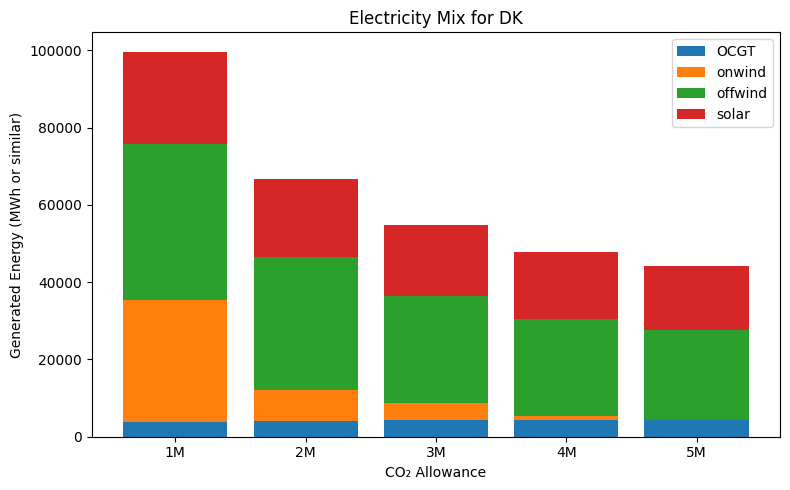

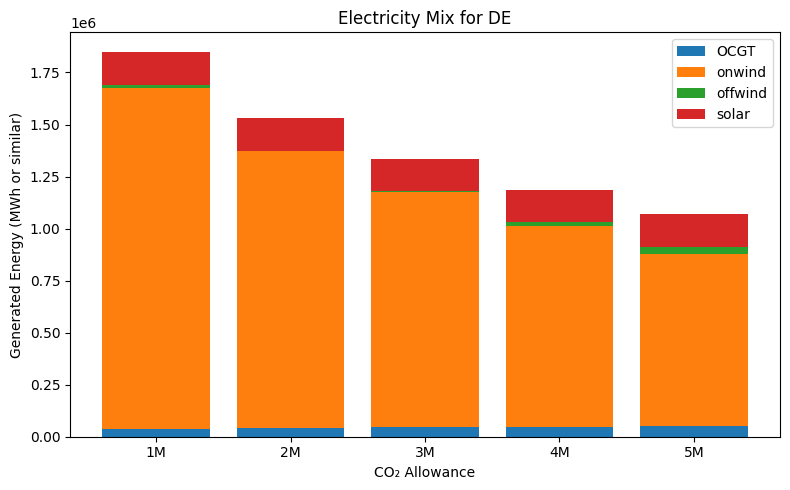

In [14]:
from NetworkB import NetworkB
import matplotlib.pyplot as plt
import numpy as np

CO2_limits = [1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000]
# CO2_limits = [1_000_000, 2_000_000]
generator_opt = {
    key: {
        'OCGT': [],
        'CCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

for CO2_limit in CO2_limits:
    tmp = NetworkB(setup = setup, cost_year = 2030, CO2_limit = CO2_limit)
    generators = tmp.network.generators.p_nom_opt.keys()
    for region in tmp.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(tmp.network.generators.p_nom_opt[generator].sum())

x = np.arange(len(CO2_limits))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val//1_000_000}M" for val in CO2_limits])
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Generated Energy (MWh or similar)")
    plt.legend()
    plt.tight_layout()
    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (5,).

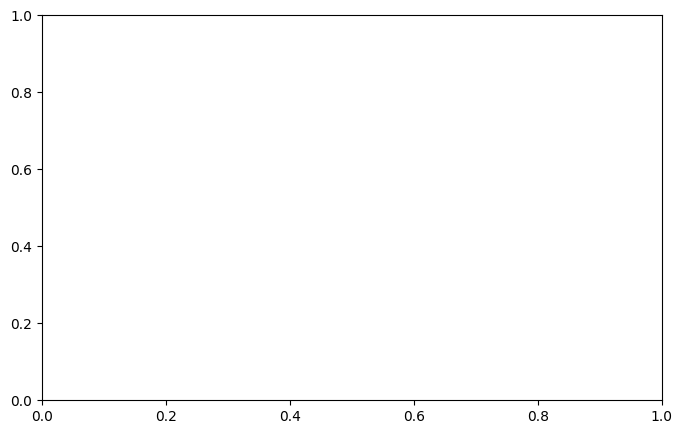

In [15]:
import numpy as np
import matplotlib.pyplot as plt

co2_levels = [1_000_000, 2_000_000]
x = np.arange(len(co2_levels))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(co2_levels))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val//1_000_000}M" for val in co2_levels])
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Generated Energy (MWh or similar)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
generator_opt

{'DK': {'OCGT': [4071.9947104894177, 4668.349988035779],
  'CCGT': [],
  'onwind': [36344.73082917612, 13119.096606339122],
  'offwind': [38826.74741791382, 33133.99244165069],
  'solar': [25558.171642709018, 20798.77832007141]},
 'DE': {'OCGT': [54362.28571428571, 58475.948651997125],
  'CCGT': [],
  'onwind': [1724476.1904761903, 1381670.9456669064],
  'offwind': [],
  'solar': [189171.5128529288, 169655.7584327821]}}

In [ ]:
setup = {'DK_1': 
                            {'OCGT': True,
                            'CCGT': True,
                            'battery storage': True,
                            'onshore wind': True,
                            'solar': True},
        'DE':  {'OCGT': True,
                'CCGT': True,
                'battery storage': False,
                'onshore wind': True,
                'solar': True}}

In [ ]:
import numpy as np
tmp.data_dict['DK']['Demand'].values.flatten()

array([3186.04, 3070.07, 2966.19, ..., 3438.26, 3309.25, 3315.91])

Det er noteret at:

In [ ]:
plt.plot(DataGeneration(year = 2019, region = 'DK_1').data['wind_offshore_generation_actual'].values)
plt.show()


Year 2018 is greater than 2017, using data from last available year.
Year 2019 is greater than 2017, using data from last available year.
Year 2020 is greater than 2017, using data from last available year.


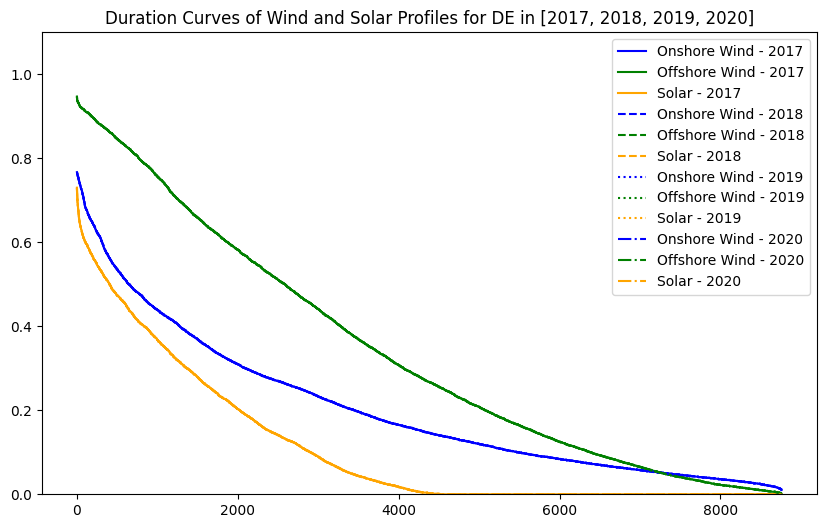

NameError: name 'plt' is not defined

In [ ]:
from DurationCurve import DurationCurve

# region = 'DK_1'
# region = 'DK_2'
# region = 'NO'
region = 'DE'

years = [2017, 2018, 2019, 2020]

DurationCurve(years = years, region = region)
plt.show()

# Testing plots 

# Task D

In [16]:
# Basemodel with DK
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
                }

BBN = BuildBaseNetwork(setup = setup)

# addition of battery storage
BBN.network.add(
    "StorageUnit",
    "battery storage",
    bus=f"electricity bus DK",
    carrier="battery storage",
    max_hours=2,
    capital_cost=BBN.costs.at["battery inverter", "capital_cost"]
    + 2 * BBN.costs.at["battery storage", "capital_cost"],
    efficiency_store=BBN.costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=BBN.costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['battery storage'], dtype='object')

In [17]:
# hydrogen bus
BBN.network.add("Bus", "hydrogen bus DK", carrier="hydrogen")

# electrolyzer
BBN.network.add(
    "Link",
    "electrolyzer DK",
    bus0="electricity bus DK",
    bus1="hydrogen bus DK",
    carrier="electrolyzer",
    efficiency=BBN.costs.at["electrolysis", "efficiency"],  # e.g., 0.75
    capital_cost=BBN.costs.at["electrolysis", "capital_cost"],
    p_nom_extendable=True,
)
# hydrogen storage - unlimited energy capacity
BBN.network.add(
    "StorageUnit",
    "hydrogen storage DK",
    bus="hydrogen bus DK",
    carrier="hydrogen storage",
    capital_cost=BBN.costs.at["hydrogen storage underground", "capital_cost"],
    e_nom_extendable=True,
)
# fuel cell
BBN.network.add(
    "Link",
    "fuel cell DK",
    bus0="hydrogen bus DK",
    bus1="electricity bus DK",
    carrier="fuel cell",
    efficiency=BBN.costs.at["fuel cell", "efficiency"],  # e.g., 0.5
    capital_cost=BBN.costs.at["fuel cell", "capital_cost"],
    p_nom_extendable=True,
)

Index(['fuel cell DK'], dtype='object')

In [18]:
BBN.network.optimize(solver_name="gurobi",solver_options={"OutputFlag": 0})

Index(['electrolyzer DK', 'fuel cell DK'], dtype='object', name='Link')
Index(['battery storage', 'hydrogen storage DK'], dtype='object', name='StorageUnit')
Index(['electricity bus DK', 'hydrogen bus DK'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 34.38it/s]
INFO:linopy.io: Writing time: 1.78s


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-qhj7ivbi.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\jonat\AppData\Local\Temp\linopy-problem-qhj7ivbi.lp


Reading time = 0.48 seconds


INFO:gurobipy.gurobipy:Reading time = 0.48 seconds


obj: 245288 rows, 105127 columns, 459924 nonzeros


INFO:gurobipy.gurobipy:obj: 245288 rows, 105127 columns, 459924 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105127 primals, 245288 duals
Objective: 2.17e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [19]:
BBN.network.generators.p_nom_opt

Generator
OCGT DK       4763.874591
solar DK      1505.270014
offwind DK     793.567513
onwind DK     5500.000000
Name: p_nom_opt, dtype: float64

In [20]:
BBN.network.storage_units.p_nom_opt

StorageUnit
battery storage        557.201897
hydrogen storage DK      0.000000
Name: p_nom_opt, dtype: float64

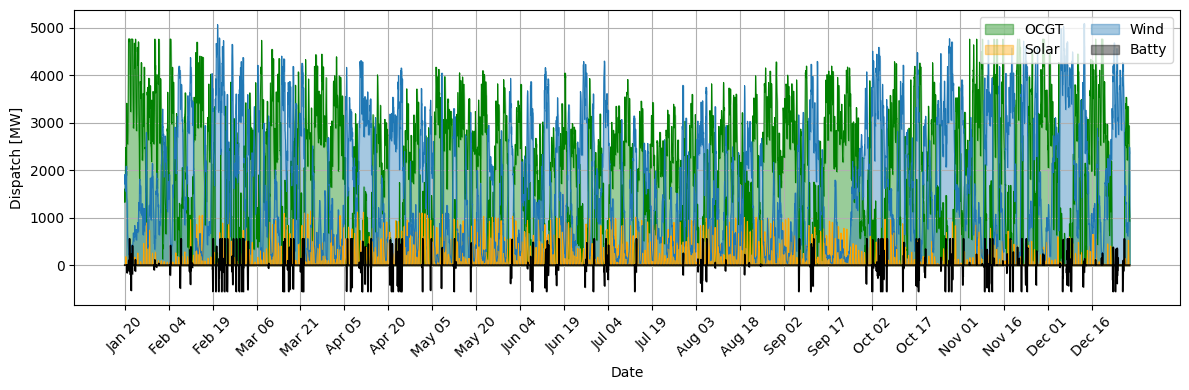

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_dispatch(BBN, period=None):
    """
    Plots the dispatch for selected generators and storage over time.
    
    Parameters:
    - BBN: PyPSA network object.
    - period: tuple of (start_date, end_date) in 'YYYY-MM-DD' format, optional.
              If None, the full time range is plotted.
    """

    # Power series - generators
    ocgt = BBN.network.generators_t.p['OCGT DK']
    solar = BBN.network.generators_t.p['solar DK']
    wind = BBN.network.generators_t.p['offwind DK'] + BBN.network.generators_t.p['onwind DK']

    # Power series - storage units
    battery = BBN.network.storage_units_t.p['battery storage']

    # Combine into a DataFrame for easy slicing
    df = pd.DataFrame({
        'OCGT': ocgt,
        'Solar': solar,
        'Wind': wind,
        'Battery': battery
    })

    # Apply period filtering if specified
    if period is not None:
        start, end = period
        df = df.loc[start:end]

    x = df.index

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.fill_between(x, df['OCGT'], label='OCGT', color='green', alpha=0.4)
    plt.fill_between(x, df['Solar'], label='Solar', color='orange', alpha=0.4)
    plt.fill_between(x, df['Wind'], label='Wind', color='tab:blue', alpha=0.4)
    plt.fill_between(x, df['Battery'], label='Batty', color='black', alpha=0.4)

    plt.plot(x, df['OCGT'], color='green', linewidth=0.7)
    plt.plot(x, df['Solar'], color='orange', linewidth=0.7)
    plt.plot(x, df['Wind'], color='tab:blue', linewidth=0.7)
    plt.plot(x, df['Battery'], color='black', linewidth=1.1)

    # Adjust x-ticks
    duration_hours = (x[-1] - x[0]).total_seconds() / 3600
    if duration_hours <= 72:  # 3 days
        tick_interval = 6
        date_format = '%b %d %H:%M'
    elif duration_hours <= 168:  # 1 week
        tick_interval = 12
        date_format = '%b %d %H:%M'
    elif duration_hours <= 720:  # 1 month
        tick_interval = 24
        date_format = '%b %d'
    else:
        tick_interval = 24 * 15
        date_format = '%b %d'

    tick_locs = x[::tick_interval]
    tick_labels = tick_locs.strftime(date_format)

    plt.xticks(tick_locs, tick_labels, rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Dispatch [MW]')
    plt.tight_layout()
    plt.grid(True)
    plt.legend(ncol=2, loc='upper right')

plot_dispatch(BBN, period=('2017-01-20', '2017-12-28'))